In [63]:
import random
import string
from tabulate import tabulate

class Word_search_puzzle(object):
    # Initialize importance variables.
    def __init__(self, word_number, width, height, difficulty):

        ### Define by user
        self.word_number = word_number
        self.width = width
        self.height = height
        self.difficulty = difficulty
        ###


        self.used_dir = list()
        self.word_corr_dict = dict()
        self.terminate_counter = 0
        self.direction_order = list()

    # read data from text file that we used.
    def read_data(self):
        file = open('GSL_word.txt', 'r') #http://jbauman.com/gsl.html
        contents = file.read()
        contents = contents.split('\n') # Seperate chunk of text into substring
        file.close()
        return contents

    # Get the random list of word accroding to difficulty or get extra_word.
    def get_random_word(self, extra_word=False):

        # Check if have the contents in the memory. If not get the contents.
        if 'contents' not in locals():
            contents = self.read_data()

        # Try catch: if we cannot fit the word into the board, then get the new word with less lenght.
        if extra_word == True:
            word_lenght = min(self.height, self.width) // 2
            wordpool = [word for word in contents if (len(word) < word_lenght) and (len(word) < self.width) and (len(word) < self.height)]
            playword = random.choice(wordpool)
            return playword

        ### Normal route ###
        # Assign the lenght of word according to difficulty.
        if self.difficulty.lower() == 'hard':
            word_lenght = 5
        elif self.difficulty.lower() == 'normal':
            word_lenght = 3
        elif self.difficulty.lower() == 'easy':
            word_lenght = 2
        # Try catch: grid is too small.
        if min(self.height, self.width) <= word_lenght:
            raise Exception("Cannot fit all the word into the grid, Please decrease the difficulty or increase grid size")
        
        # wordpool list comprehension is used to find the word that not exceed the grid size (h, w)
        # and used the find the word according to the difficulty
        wordpool = [word for word in contents if (len(word) > word_lenght) and (len(word) < self.width) and (len(word) < self.height)]
        playword = random.choices(wordpool, k=self.word_number)

        return playword

    # Generate the plain board (list)
    def generate_plain(self):
        plain = list()
        for _ in range(self.width):
            plain.append(['_' for i in range(self.height)])
        return plain

    # Get used direction according to difficulty.
    def get_direction(self):

        directionpool = ['S', 'E', 'N', 'W', 'NE', 'SE', 'SW', 'NW']

        if self.difficulty.lower() == 'hard':
            directionnum = 8
        elif self.difficulty.lower() == 'normal':
            directionnum = 4
        elif self.difficulty.lower() == 'easy':
            directionnum = 2
        
        usedirection = directionpool[:directionnum]

        return usedirection

    # Randomly get the starting corrdinate according to word lenght.
    def get_starting_point(self, direction, word_lenght):

        upper_x = self.height - 1
        upper_y = self.width - 1
        lower_x = 0
        lower_y = 0

        if 'S' in direction:
            upper_x = self.height - word_lenght
        if 'E' in direction:
            upper_y = self.width - word_lenght
        if 'N' in direction:
            lower_x = word_lenght - 1
        if 'W' in direction:
            lower_y = word_lenght - 1

        # Random from legit starting point
        x = random.randint(lower_x, upper_x)
        y = random.randint(lower_y, upper_y)

        return x, y

    def get_starting_point_naive(self):

        x = random.randint(0, self.height - 1)
        y = random.randint(0, self.width - 1)

        return x, y

    # Find word end coordinate by using the start coordinate
    def get_ending_point(self, direction, x, y, word_lenght):
        word_lenght = word_lenght - 1
        ending_x = x
        ending_y = y
        if 'S' in direction:
            ending_x = x + word_lenght
        if 'E' in direction:
            ending_y = y + word_lenght
        if 'N' in direction:
            ending_x = x - word_lenght
        if 'W' in direction:
            ending_y = y - word_lenght
    
        return ending_x, ending_y

    # Find all the coordinate that have been used for one word.
    def calc_path_used(self, x, y, endx, endy):
        list_path_x = list()
        list_path_y = list()
        change_case = 0

        # If it go to the left or north side then swap the starting point and end point.
        # Basically, minus coordinate.
        if endx < x:
            x, endx = endx, x
        if endy < y:
            y, endy = endy, y

        # Case 1 only x change
        if (endx - x != 0) and (endy - y == 0):
            list_path_y.append(y)
            word_lenght = (abs(endx - x)) + 1
            counter = 0
            while counter < word_lenght:
                list_path_x.append(x + counter)
                counter += 1
            change_case = 1

        # Case 2 only y change
        elif (endx - x == 0) and (endy - y != 0):
            list_path_x.append(x)
            word_lenght = (abs(endy - y)) + 1
            counter = 0
            while counter < word_lenght:
                list_path_y.append(y + counter)
                counter += 1
            change_case = 1

        # Case 3 both x and y change    
        else:
            word_lenght = (abs(endx - x)) + 1
            counter = 0
            while counter < word_lenght:
                list_path_x.append(x + counter)
                list_path_y.append(y + counter)
                counter += 1
    
        used_point = list()
        if change_case == 1: # Case 1, 2
            # Convert it to list of (x, y) coordinate.
            for ix in list_path_x:
                for iy in list_path_y:
                    used_point.append((ix, iy))
            return used_point
        else:
            return list(zip(list_path_x, list_path_y))

    # Naive ways to check if the coordinate used for the current word conflict with the word before.
    def check_path_collide_naive(self, current_path):
        # This means the board is currently empty.
        if len(self.used_dir) == 0:
            return False
        
        for used_corr in self.used_dir:
            for curr_corr in current_path:
                if used_corr == curr_corr:
                    return True
        
        return False

    # Better ways
    def check_path_collide(self, current_path):
        return not set(self.used_dir).isdisjoint(current_path)

    def generate_puzzle(self):
        self.board = self.generate_plain()

        # Change character in board accroding to the word and its coordinate.
        for i, word in enumerate(self.word_corr_dict):

            # place word in reverse order.
            if ('W' in self.direction_order[i]) or ('N' in self.direction_order[i]):
                for index, char in enumerate(word[::-1]):
                    self.board[self.word_corr_dict[word][index][0]][self.word_corr_dict[word][index][1]] = char.upper()
            else:
                # place word normally.
                for index, char in enumerate(word):
                    self.board[self.word_corr_dict[word][index][0]][self.word_corr_dict[word][index][1]] = char.upper()

        # Replace '_' with some random upper character.
        for x, row in enumerate(self.board):
            for y, c in enumerate(row):
                if c == '_':
                    self.board[x][y] = random.choice(string.ascii_uppercase)

        # Printing the board
        print(tabulate(self.board, headers=[i for i in range(self.width)], showindex='always', tablefmt='simple_grid'))
        print(f'Here is your puzzle, Have fun!')
        print([word.upper() for word in list(self.word_corr_dict.keys())])

    def check_in_grid(self, x, y):
        if (x < self.height) and (y < self.width):
            return True
        else:
            return False

    def main(self):
        # Get the list of word.
        wordlist = self.get_random_word()
        # Get the list of direction 
        usedirection = self.get_direction()

        # Use queue, do until queue is exhausted.
        while wordlist:
            word = wordlist.pop(0)
            counter = 0
            boo_path_collide = True
            #check_legit = False # Naive
            while (boo_path_collide == True) and (counter < 1000):
                    # Get random direction from direction list.
                    direction = random.choice(usedirection)

                    ### NAIVE ###
                    # while (check_legit == False):
                    #     # Get staring point naive
                    #     startx, starty = self.get_starting_point_naive()

                    #     # Get ending coordinate
                    #     endx, endy = self.get_ending_point(direction, startx, starty, len(word))

                    #     # Check legit
                    #     check_legit = self.check_in_grid(endx, endy)

                    # # Get the list of tuple of starting corrdinate to ending corrdinate.
                    # curr_path = self.calc_path_used(startx, starty, endx, endy)

                    # # Check if path collide
                    # boo_path_collide = self.check_path_collide(curr_path)

                    # ### END OF NAIVE ###

                    ## REAL ALGORITHMS ###

                    # Get starting coordinate.
                    startx, starty = self.get_starting_point(direction, len(word))
                    
                    # Get ending coordinate
                    endx, endy = self.get_ending_point(direction, startx, starty, len(word))
                    
                    # Get the list of tuple of starting corrdinate to ending corrdinate.
                    curr_path = self.calc_path_used(startx, starty, endx, endy)

                    # Check if path collide (naive)
                    #boo_path_collide = self.check_path_collide_naive(curr_path)

                    # Check if path collide
                    boo_path_collide = self.check_path_collide(curr_path)

                    ### END OF REAL ALGORITHMS

                    # Append to used_dir if not collide otherwise repeat.
                    if boo_path_collide == False:
                            self.used_dir.extend(curr_path)
                            self.word_corr_dict[word] = curr_path # CAT : [(1, 3), (2, 3), (3, 3)]
                            self.direction_order.append(direction) # [E, S, W, .........]
                            break
                    
                    counter += 1
            if boo_path_collide == True:
                    if self.terminate_counter == 200:
                            raise Exception("Cannot fit all the word into the grid, Please decrease the number of word or increase the grid size")
                            #return None # For using timeit function
                    else:
                            wordlist.append(self.get_random_word(extra_word=True))
                            self.terminate_counter += 1

        self.generate_puzzle()

    def solution(self):
        for index, word in enumerate(self.word_corr_dict):
            if 'W' in self.direction_order[index] or 'N' in self.direction_order[index]:
                startfrom = self.word_corr_dict[word][-1]
            else:
                startfrom = self.word_corr_dict[word][0]

            print(f'Word: {word.upper()} direction: {self.direction_order[index]} starting point {startfrom}')

In [64]:
word_number = 10
width = 10
height = 10
difficulty = 'hard'
testing = Word_search_puzzle(word_number, width, height, difficulty)

In [65]:
testing.main()

┌────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│    │ 0   │ 1   │ 2   │ 3   │ 4   │ 5   │ 6   │ 7   │ 8   │ 9   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  0 │ G   │ D   │ L   │ G   │ H   │ X   │ A   │ K   │ C   │ N   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  1 │ U   │ V   │ D   │ O   │ N   │ B   │ K   │ X   │ N   │ O   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  2 │ R   │ I   │ R   │ B   │ R   │ O   │ D   │ B   │ Q   │ O   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  3 │ N   │ E   │ L   │ H   │ P   │ T   │ R   │ M   │ Y   │ N   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  4 │ I   │ O   │ H   │ S   │ S   │ F   │ N   │ T   │ I   │ R   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  5 │ F   │ L   │ T   │ T   │ Y   │ I   │ C   │ O   │ S   │ E   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼──

In [66]:
testing.solution()

Word: RUBBISH direction: NE starting point (9, 9)
Word: SYSTEM direction: SE starting point (4, 3)
Word: ENGINEER direction: NW starting point (9, 7)
Word: GATHER direction: NW starting point (7, 5)
Word: AFTERNOON direction: N starting point (8, 9)
Word: STRONG direction: W starting point (5, 8)
Word: BUTTON direction: SW starting point (8, 5)
Word: CONTROL direction: NE starting point (6, 8)
Word: TOO direction: NE starting point (8, 2)


In [ ]:
from timeit import timeit
import numpy as np
import matplotlib.pyplot as plt
from random import sample

# The range of n will be between 10 and 1000 with a growth rate of 10 per iteration
num_samples = range(10, 100, 5)

# The constant value c shows somewhat of a match between nlogn and the algorithm
# This is probably  true for my PC due to hardware and might be a different value for other
c = 1/430000

def setup_code(n):
    return Word_search_puzzle(n, n, n, 'hard')

timevals = []


y_nlogn = []
for n in num_samples:
    my_list = sample(range(n), n)
    y_nlogn.append(c * n * np.log(n)) # For n log n run times

    time = timeit(setup='testing = setup_code(n)',
                stmt='testing.main()', number=1, globals=globals())
    timevals.append(time)
#plt.plot(num_samples, y_nlogn, label='nlogn')
plt.plot(num_samples, timevals, label='Code Runtime')
plt.legend()
plt.show()

In [38]:
# Naive runtime
Naive_runtime = timevals


In [50]:
Naive_runtime

[0.12198559999978897,
 0.21300150000024587,
 0.2778926999999385,
 0.4231930999994802,
 0.4357393999998749,
 0.4029676999998628,
 0.3439358000005086,
 0.3682332000007591,
 0.3052981999999247,
 0.38134200000058627,
 0.5919530999999552,
 0.6740821000003052,
 0.5575341000003391,
 0.49952290000055655,
 0.48076940000009927,
 0.5604584000002433,
 0.6519690999994054,
 0.5895910999997795]

In [30]:
# Naive collide
Naive_collide_runtime = timevals

In [51]:
Naive_collide_runtime

[0.007870200000070326,
 0.013947299999927054,
 0.01861170000029233,
 0.02286980000008043,
 0.028044600000612263,
 0.034454399999958696,
 0.037294200000360433,
 0.039636000000427885,
 0.05541969999922003,
 0.08118259999992006,
 0.07434589999957097,
 0.07784350000019913,
 0.10806000000047788,
 0.12606240000059188,
 0.1691638000002058,
 0.15432849999979226,
 0.18303000000014435,
 0.19412850000026083]

In [33]:
# Non Naive
runtime = timevals

In [52]:
runtime

[0.027481000000079803,
 0.008238700000219978,
 0.016965699999673234,
 0.018012800000178686,
 0.024839100000463077,
 0.035018599999602884,
 0.03521569999975327,
 0.035722700000405894,
 0.04532950000066194,
 0.06415670000023965,
 0.05974100000003091,
 0.07105480000063835,
 0.10575349999999162,
 0.09569850000025326,
 0.11792700000023615,
 0.18302330000005895,
 0.14623180000035063,
 0.1605466000000888]

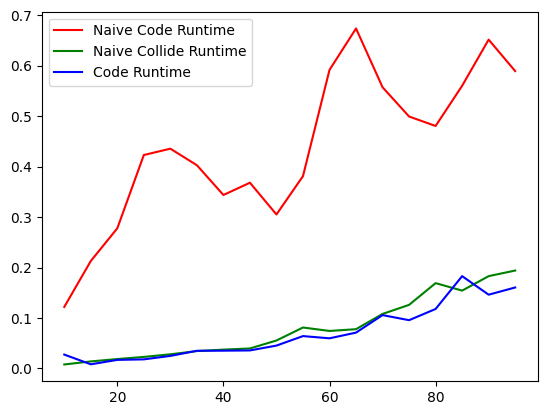

In [39]:
num_samples = range(10, 100, 5)
plt.plot(num_samples, Naive_runtime, label='Naive Code Runtime', c='r')
plt.plot(num_samples, Naive_collide_runtime, label='Naive Collide Runtime', c='g')
plt.plot(num_samples, runtime, label='Code Runtime', c='b')
plt.legend()